<a href="https://colab.research.google.com/github/TaeGongKim/tensorflow-developer/blob/main/Convolutional%20Neural%20Networks%20in%20TensorFlow/Horses_vs_humans_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

In [2]:
# inceptionV3 weights download
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" \
    -O "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# horse or human dataset download
!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip" \
    -O "/tmp/horse-or-human.zip"

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip" \
    -O "/tmp/validation-horse-or-human.zip"

--2021-10-15 18:18:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 64.233.166.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  51.1MB/s    in 1.6s    

2021-10-15 18:18:26 (51.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

--2021-10-15 18:18:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 64.233.166.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.1

In [3]:
# Get the Horse or Human dataset
path_horse_or_human = f"{getcwd()}/../tmp/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"{getcwd()}/../tmp/validation-horse-or-human.zip"


local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [9]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/horses'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [4]:
path_inception = f"{getcwd()}/../tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

# include_top : DNN layer 포함 여부
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
callbacks = myCallback()

In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation = 'sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss =  'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    target_size = (150, 150),
                                                    class_mode = 'binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 20,
                                                         target_size = (150, 150),
                                                         class_mode = 'binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [15]:
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = 20,
                              callbacks = [callbacks])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 [==============================] - 14s 268ms/step - loss: 0.0204 - accuracy: 0.9932 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/20
52/52 [==============================] - 14s 261ms/step - loss: 0.0479 - accuracy: 0.9825 - val_loss: 0.0822 - val_accuracy: 0.9766
Epoch 3/20
52/52 [==============================] - 14s 262ms/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.0057 - val_accuracy: 0.9961
Epoch 4/20
52/52 [==============================] - 14s 261ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.0438 - val_accuracy: 0.9844
Epoch 5/20
52/52 [==============================] - 14s 260ms/step - loss: 0.0099 - accuracy: 0.9951 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/20
52/52 [==============================] - 14s 263ms/step - loss: 0.0044 - accuracy: 0.9981 - val_loss: 0.0183 - val_accuracy: 0.9961
Epoch 7/20
52/52 [==============================] - 14s 260ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 1.2459e-04 - val_accuracy: 1.

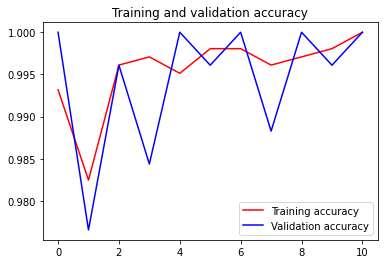

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()